## Continuous Reactor Example 
### Simulation of a CSTR/PSR/WSR 

In this example we will illustrate how Cantera can be used to simulate a **C**ontinuouly **S**tirred **T**ank **R**eactor, also interchangeably referred to as a **P**erfectly **S**tirred **R**eactor or a **W**ell **S**tirred **R**eactor, Jet Stirred Reactors or Longwell Reactors (there may well be more "aliases"). A cartoon of such a reactor is shown below

<img src="images/stirredReactorCartoon.png" alt="Cartoon of a Stirred Reactor" style="width: 300px;"/>

As the figure illustrates, this is an open system (unlike a Batch Reactor which is isolated). P, V and T are the reactor's pressure, volume and temperature respectively. The mass flow rate at which reactants come in is the same as that of the products which exit; and these stay in the reactor for a characteristic time $\tau$, called the *residence time*. This is a key quantity in sizing the reactor and is defined as follows:

\begin{equation*}
\tau = \frac{m}{\dot{m}}
\end{equation*}

where $m$ is the mass of the gas in the reactor and equals $\frac{PV}{R_{gas}T}$

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import time
import cantera as ct

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.3.0a3


### Define the gas
In this example, we will work with $nC
_{7}H_{16}$/$O_{2}$/$He$ mixtures, for which experimental data can be found in the paper by [Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001). We will use the same mechanism reported in the paper. It consists of 1268 species and 5336 reactions

In [2]:
gas = ct.Solution('data/galway.cti')



**** WARNING ****
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


**** WARNING ****
For species CH2CO, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  10.0876
	Value computed using high-temperature polynomial: 10.1013


**** WARNING ****
For species C5H9B-A,COOH, discontinuity in cp/R detected at Tmid = 1675
	Value computed using low-temperature polynomial:  47.645
	Value computed using high-temperature polynomial: 47.5845


**** WARNING ****
For species C5H9B-C,DOOH, discontinuity in cp/R detected at Tmid = 1675
	Value computed using low-temperature polynomial:  47.645
	Value computed using high-temperatu

### Define initial conditions
#### Inlet conditions for the gas and reactor parameters

In [3]:
# Inlet gas conditions
reactorTemperature = 925 #Kelvin
reactorPressure = 1.046138*ct.one_atm #in atm. This equals 1.06 bars
concentrations = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
gas.TPX = reactorTemperature, reactorPressure, concentrations 

# Reactor parameters
residenceTime = 2 #s
reactorVolume = 30.5*(1e-2)**3 #m3

# Instrument parameters

# This is the "conductance" of the pressure valve and will determine its efficiency in 
# holding the reactor pressure to the desired conditions. 
pressureValveCoefficient = 1

# This parameter will allow you to decide if the valve's conductance is acceptable. If there
# is a pressure rise in the reactor beyond this tolerance, you will get a warning
maxPressureRiseAllowed = 0.01

#### Simulation parameters

In [4]:
# Specify the the max number of iterations as well as the total max. time for iterations
# Since we will simulate a range of temperatures, we use both to provide us with judicious
# checks
maxSteps = 2000
maxSimulationTime = 50 #s

### Reactor arrangement

We showed a cartoon of the reactor in the first figure in this notebook; but to actually simulate that, we need a few peripherals. A mass-flow controller upstream of the stirred reactor will allow us to flow gases in, and in-turn, a "reservoir" which simulates a gas tank is required to supply gases to the mass flow controller. Downstream of the reactor, we install a pressure regulator which allows the reactor pressure to stay within. Downstream of the regulator we will need another reservoir which acts like a "sink" or capture tank to capture all exhaust gases (even our simulations are environmentally friendly !). This arrangment is illustrated below

<img src="images/stirredReactorCanteraSimulation.png" alt="Cartoon of a Stirred Reactor" style="width: 600px;"/>

#### Initialize the stirred reactor and connect all peripherals

In [5]:
fuelAirMixtureTank = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)

massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,\
                                           downstream=stirredReactor,\
                                           mdot=stirredReactor.mass/residenceTime)

pressureRegulator = ct.Valve(upstream=stirredReactor,\
                             downstream=exhaust,\
                             K=pressureValveCoefficient)

reactorNetwork = ct.ReactorNet([stirredReactor])

In [6]:
# now compile a list of all variables for which we will store data
columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
columnNames = ['pressure'] + columnNames

# use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=columnNames)

In [7]:
# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while((counter < maxSteps) and (t < maxSimulationTime)):
    t = reactorNetwork.step()
    
    state = reactorNetwork.get_state()
    state[3:] = stirredReactor.thermo.X
    state = np.hstack((np.array([stirredReactor.thermo.P]), state))
    
    # We will store only every 10th value. Remember, we have 1200+ species, so there will be
    # 1200 columns for us to work with
    if(counter%10 == 0):
        timeHistory.loc[t] = state
    
    counter+=1

# Stop the stopwatch
toc = time.time()

print('Simulation Took {:3.2f}s to compute, with {} steps'.format(toc-tic, counter))

# We now check to see if the pressure rise during the simulation, a.k.a the pressure valve
# was okay
pressureDifferential = timeHistory['pressure'].max()-timeHistory['pressure'].min()
if(abs(pressureDifferential/reactorPressure) > maxPressureRiseAllowed):
    print("WARNING: Non-trivial pressure rise in the reactor. Adjust K value in valve")

Simulation Took 18.10s to compute, with 1247 steps


## Plot the results

### Import modules and set plotting defaults

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True

As a test, we plot the mole fraction of $CO$ and see if the simulation has converged. If not, go back and adjust max. number of steps and/or simulation time

<IPython.core.display.Javascript object>


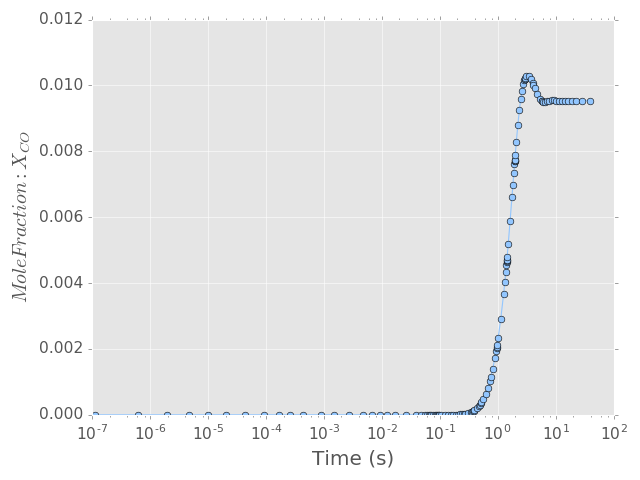

In [9]:
plt.figure()
plt.semilogx(timeHistory.index, timeHistory['CO'],'-o')
plt.xlabel('Time (s)')
plt.ylabel(r'$Mole Fraction : X_{CO}$');

## Illustration : Modeling experimental data
### Let us see if the reactor can reproduce actual experimental measurements

We first load the data. This is also supplied in the paper by [Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001) as an excel sheet

In [10]:
expData = pd.read_excel('data/zhangExpData.xlsx')
expData.head()

,T,NC7H16,O2,CO,CO2
0,500,0.005067,0.029260,0.000000,0.000000
1,525,0.004925,0.028619,0.000000,0.000000
2,550,0.004658,0.028545,0.000000,0.000000
3,575,0.004159,0.026276,0.000243,0.000101
4,600,0.003553,0.023257,0.000968,0.000251


In [11]:
# Define all the temperatures at which we will run simulations. These should overlap
# with the values reported in the paper as much as possible
T = [650, 700, 750, 775, 850, 875, 925, 950, 1075, 1100]

# Create a data frame to store values for the above points
tempDependence = pd.DataFrame(columns=timeHistory.columns)
tempDependence.index.name = 'Temperature'

Now we simply run the reactor code we used above for each temperature

In [12]:
for i, temperature in enumerate(T):
    #Re-initialize the gas
    reactorTemperature = temperature #Kelvin
    reactorPressure = 1.046138*ct.one_atm #in atm. This equals 1.06 bars
    concentrations = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
    reactorVolume = 30.5*(1e-2)**3 #m3
    gas.TPX = reactorTemperature, reactorPressure, concentrations 
    
    # Re-initialize the dataframe used to hold values
    timeHistory = pd.DataFrame(columns=columnNames)
 
    # Re-initialize all the reactors, reservoirs, etc
    fuelAirMixtureTank = ct.Reservoir(gas)
    exhaust = ct.Reservoir(gas)
    stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)
    massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,downstream=stirredReactor,\
                                               mdot=stirredReactor.mass/residenceTime)
    pressureRegulator = ct.Valve(upstream=stirredReactor, downstream=exhaust, K=pressureValveCoefficient)
    reactorNetwork = ct.ReactorNet([stirredReactor])
    
    # Re-run the isothermal simulations
    tic = time.time()
    t = 0
    counter = 1
    while((counter < maxSteps) and (t < maxSimulationTime)):
        t = reactorNetwork.step()
        counter+=1
        
    state = reactorNetwork.get_state()
    state[3:] = stirredReactor.thermo.X
    state = np.hstack((np.array([stirredReactor.thermo.P]), state))
    timeHistory.loc[t] = state

    toc = time.time()
    print('Simulation at T={}K took {:3.2f}s to compute, with {} steps'.format(temperature, toc-tic, counter))
    
    # Store the result in the dataframe that indexes by temperature
    tempDependence.loc[temperature] = timeHistory.iloc[-1]

Simulation at T=650K took 15.54s to compute, with 1147 steps
Simulation at T=700K took 8.05s to compute, with 575 steps
Simulation at T=750K took 6.97s to compute, with 553 steps
Simulation at T=775K took 8.14s to compute, with 599 steps
Simulation at T=850K took 11.94s to compute, with 986 steps
Simulation at T=875K took 13.56s to compute, with 1025 steps
Simulation at T=925K took 14.75s to compute, with 1247 steps
Simulation at T=950K took 20.54s to compute, with 1404 steps
Simulation at T=1075K took 18.28s to compute, with 1500 steps
Simulation at T=1100K took 21.76s to compute, with 1666 steps


### Compare the model results with experimental data

<IPython.core.display.Javascript object>


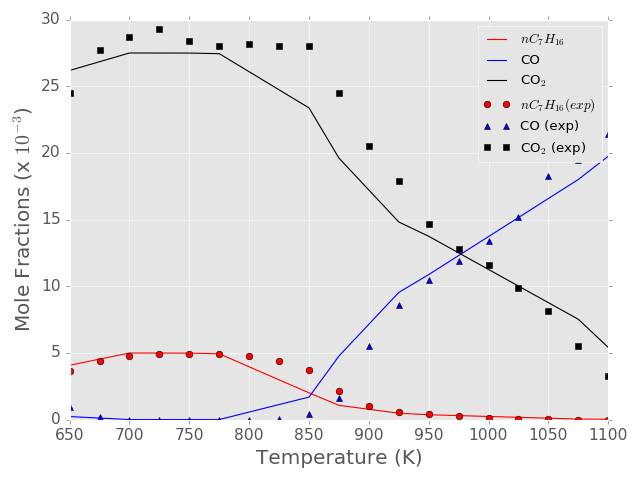

In [13]:
plt.figure()
plt.plot(tempDependence.index, tempDependence['NC7H16']*1000, 'r-', label=r'$nC_{7}H_{16}$')
plt.plot(tempDependence.index, tempDependence['CO']*1000, 'b-', label='CO')
plt.plot(tempDependence.index, tempDependence['O2']*1000, 'k-', label='CO$_{2}$')

plt.plot(expData['T'], expData['NC7H16']*1000,'ro', label=r'$nC_{7}H_{16} (exp)$')
plt.plot(expData['T'], expData['CO']*1000,'b^', label='CO (exp)')
plt.plot(expData['T'], expData['O2']*1000,'ks', label='CO$_{2}$ (exp)')

plt.xlabel('Temperature (K)')
plt.ylabel(r'Mole Fractions (x $10^{-3}$)')

plt.xlim([650, 1100])
plt.legend(loc=1);